# Project 4: Advanced Lane Finding
In this project, I will complete an advanced lane finding function that includes:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms (the S-channel of HSV colour space) and gradients, to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Finally, Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Step 0: Import the library that will be needed
Import the all library of python that will be applying

In [69]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Step 1: Camera Calibration with OpenCV
Firstly, we should look at the images that we will apply to calibrate the camera.

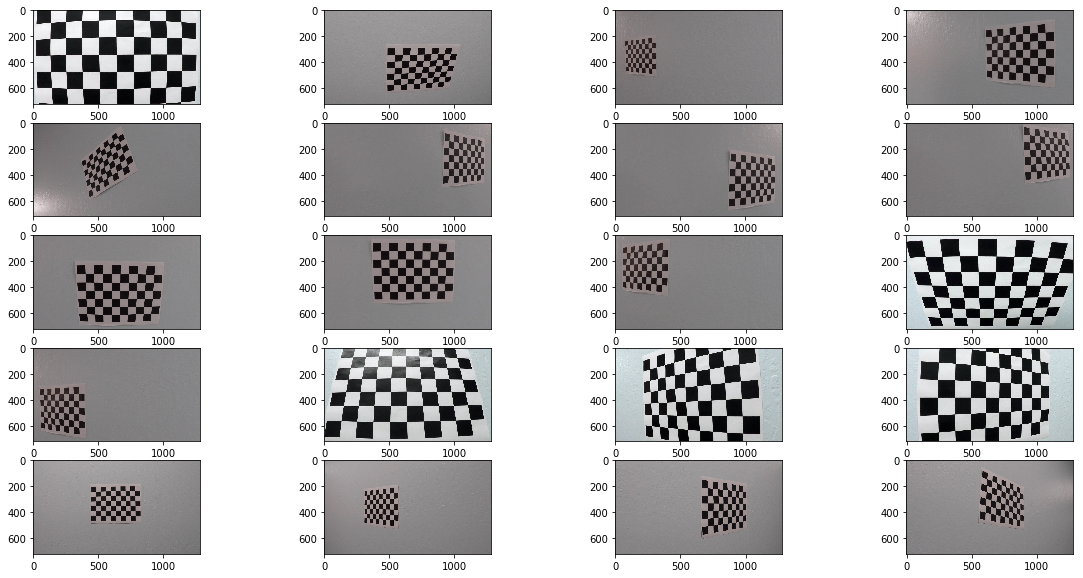

In [4]:
%matplotlib inline
images = glob.glob("camera_cal/calibration*.jpg")

plt.figure(figsize=(20, 10))

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
        
    plt.subplot(len(images)//4, 4, idx+1)
    plt.imshow(img)

Run the code in the cell below to extract object points and image points for camera calibration.
This chessboard is made with 6x9. So we should change the value which will be applied to check chessboard.

In [7]:
%matplotlib qt
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Now I success to run the above code. Next I should have objpoints and imgpoints needed for camera calibration. I will run the cell below to calibrate the camera.

In [10]:
# Do camera calibration given object points and image points
img = cv2.imread('camera_cal/calibration13.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

## Step 2: Undistort the Image
I define the function for calculating distortion coefficients and test undistortion on an image.

In [11]:
def undistort_func(img, mtx=mtx, dist=dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

I will confirm the above function.

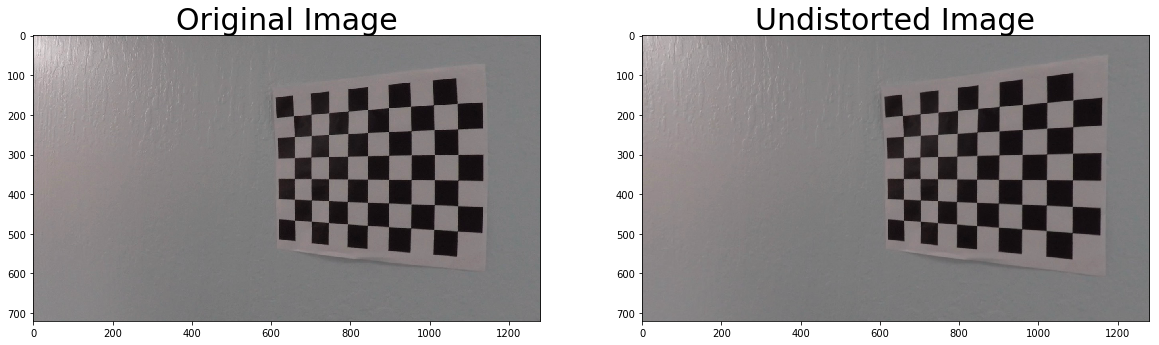

In [12]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration12.jpg')

dst = undistort_func(img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Step 3: Gradient transform and color transform
Here I will define the helpful function that is impled the gradient transform and color transform.

In [13]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_thresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def s_channel_trans(img, s_thresh=(170, 255)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

## Step 4: Perspective Transformation
I define a function which apply perspective transformation on provided image to gain a birds-eye-vies. The change is besed on the source and destination image points.

In [57]:
def warp_image(img, src_point, dst_point, img_size):
    M = cv2.getPerspectiveTransform(src_point, dst_point)
    Minv = cv2.getPerspectiveTransform(dst_point, src_point)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

Before we apply the Perspective Transformation on image, we should know the source points and destination points which we apply on image. So we should construct source and destination points in the image for determing the perspective transform matrix.

The shape of images which we will apply the function is same. And more important thing is that position of camera is treated on same place. Similar to how we masked out all but a region in the first project, I choose to pick out a region of the road looking forward image as  the source points. For the detination points I have used the full rectangle of the image.

True

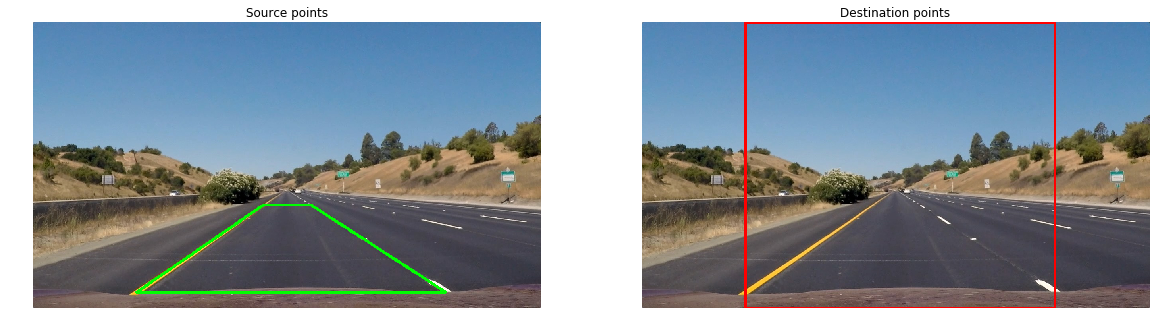

In [170]:
def get_need_warp_points(image):
    image_height = image.shape[0]
    image_width = image.shape[1]

    corners = np.float32([
        [0.18*image_width,0.95*image_height],
        [0.43*image_width,0.65*image_height],
        [0.57*image_width,0.65*image_height],
        [0.83*image_width,0.95*image_height]
    ])
    
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    
    src_point = np.float32([
        [580, 460],
        [700, 460],
        [1040, 680],
        [260, 680],
    ])

    dst_point = np.float32([
        [260, 0],
        [1040, 0],
        [1040, 720],
        [260, 720],
    ])
    
    #src_point = np.float32([corners[0], corners[1], corners[2], corners[3]])
    #dst_point = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    return src_point, dst_point

image = cv2.imread("test_images/straight_lines1.jpg")
src_point, dst_point = get_need_warp_points(image)

# Plot the chosen source and destination points on the original image
points_image_src = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points_image_dst = points_image_src.copy()


src_pts = src_point.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_src, [src_pts], True, (0, 255, 0), thickness=5)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(points_image_src)
plt.title("Source points")
plt.axis("off")
cv2.imwrite("output_images/source_points.jpg", points_image_src)

dst_pts = dst_point.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_dst, [dst_pts], True, (255, 0, 0), thickness=5)

plt.subplot(1, 2, 2)
plt.imshow(points_image_dst)
plt.title("Destination points")
plt.axis("off")
cv2.imwrite("output_images/destination_points.jpg", points_image_dst)

Now we define and imply the needed functions. We can apply those function on a test image.

(-0.5, 1279.5, 719.5, -0.5)

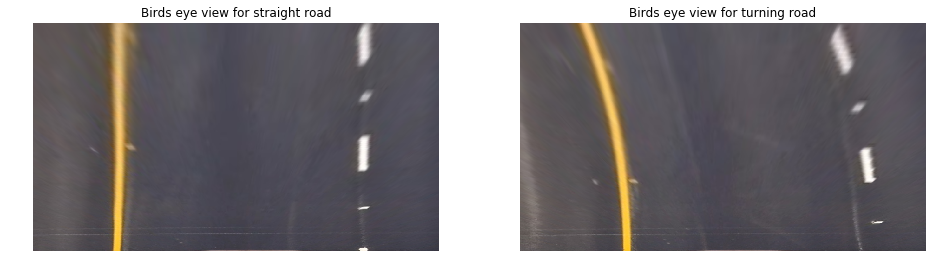

In [171]:
# Read in the same test image as used above and plot
image = cv2.imread("test_images/straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = undistort_func(image, mtx, dist)
src, dst = get_need_warp_points(image)
warped, _, _ = warp_image(image, src, dst, (image.shape[1], image.shape[0]))
cv2.imwrite("output_images/warped_straight_lines1.jpg", warped)

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(warped)
plt.title("Birds eye view for straight road");
plt.axis("off")

# Read in an image with straight lane lines to check the warped lines are parallel
image2 = cv2.imread("test_images/test2.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image2 = undistort_func(image2, mtx, dist)
warped2, _, _ = warp_image(image2, src, dst, (image2.shape[1], image2.shape[0]))
cv2.imwrite("output_images/warped_test2.jpg", warped2)

plt.subplot(1, 2, 2)
plt.imshow(warped2)
plt.title("Birds eye view for turning road")
plt.axis("off")

We define and imply the function of Gradient transform and color transform. But in the project, we should choose some of them to combine for image. So according to the program, I choose the the gradient in the X direction (finds vertical lines better) and threshold the S-channel in the HSV colour-space. Let us look at it below:

True

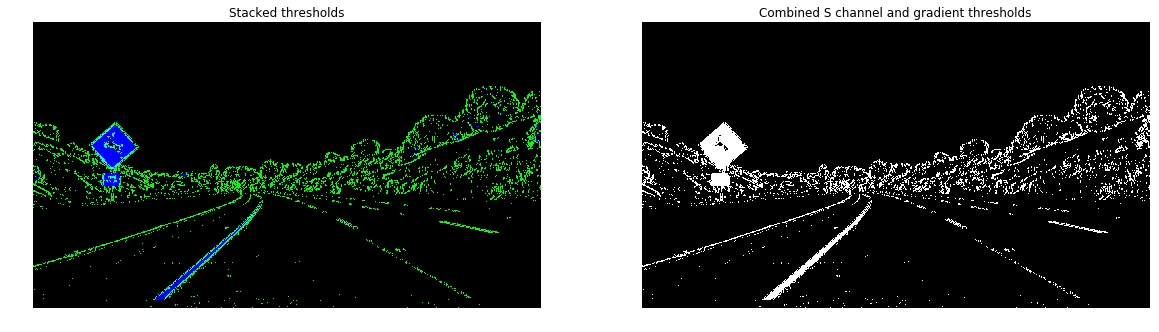

In [216]:
def combine_binary_func(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    absx = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(20, 100))
    absy = abs_sobel_thresh(gray, orient='y', sobel_kernel=3, thresh=(20, 100))
    magnitude = mag_thresh(gray, sobel_kernel=3, mag_thresh=(50, 255))
    direction = dir_thresh(gray, sobel_kernel=3, thresh=(0.7, 1.3))
    gradient = np.zeros_like(gray)
    gradient[((absx == 1) & (absy == 1)) | ((magnitude == 1) & (direction == 1))] = 1
        
    # Sobel x
    #thresh_min = 20
    #thresh_max = 100
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #gradient = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(thresh_min, thresh_max))
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = s_channel_trans(image, s_thresh=(s_thresh_min, s_thresh_max))
    
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(gradient), gradient, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradient)
    combined_binary[(s_binary == 1) | (gradient == 1)] = 1

    return color_binary, combined_binary

img = cv2.imread("test_images/test2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort_func(img, mtx, dist)
color_binary, combined_binary = combine_binary_func(undistorted_img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)
ax1.axis("off");

# save as file
binary = 255 * color_binary.astype("uint8")
binary = cv2.cvtColor(binary, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/color_binary.jpg", binary)

ax2.set_title("Combined S channel and gradient thresholds")
ax2.imshow(combined_binary, cmap="gray")
ax2.axis("off")

# save as file
binary = 255 * combined_binary.astype("uint8")
cv2.imwrite("output_images/combined_binary.jpg", binary)

After the operation above, we can get the well nice picture about that lane line can be clearly see. Next we can apply our distortion function to get a birds-eye-view image on combined image.

True

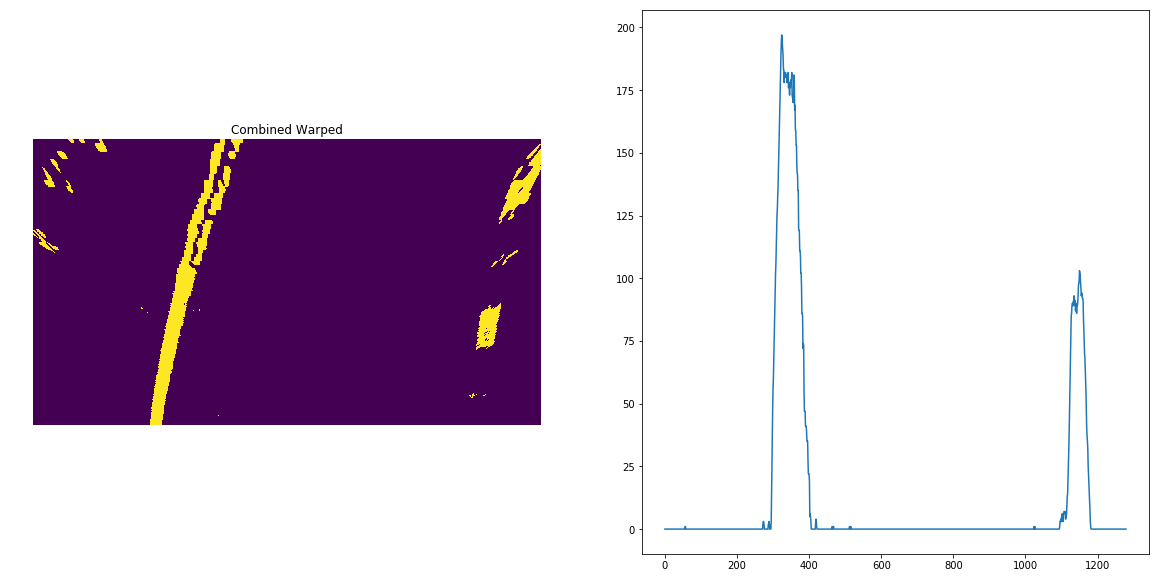

In [192]:
combined_binary_warped, _, Minv = warp_image(combined_binary, src, dst, (img.shape[1], img.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Combined Warped")
ax1.imshow(combined_binary_warped)
ax1.axis("off")

# Take a histogram of the bottom half of the image
histogram = np.sum(combined_binary_warped[np.int(combined_binary_warped.shape[0]/2):,:], axis=0)

plt.plot(histogram)

# save image
binary = 255 * combined_binary_warped.astype("uint8")
cv2.imwrite("output_images/combined_binary_warped.jpg", binary)

Let us look at the effect of all test images.

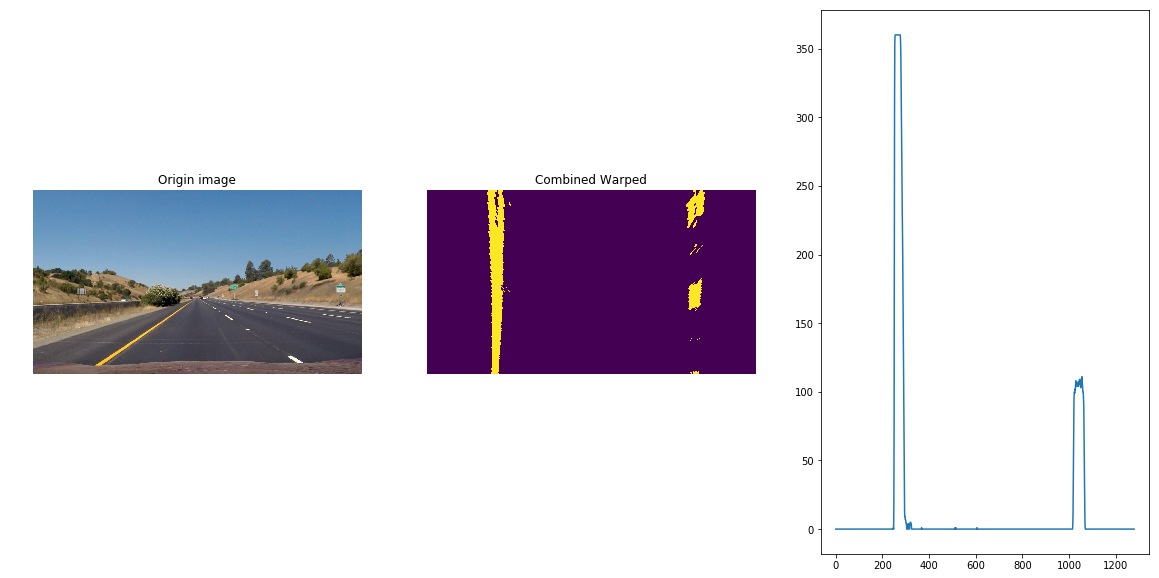

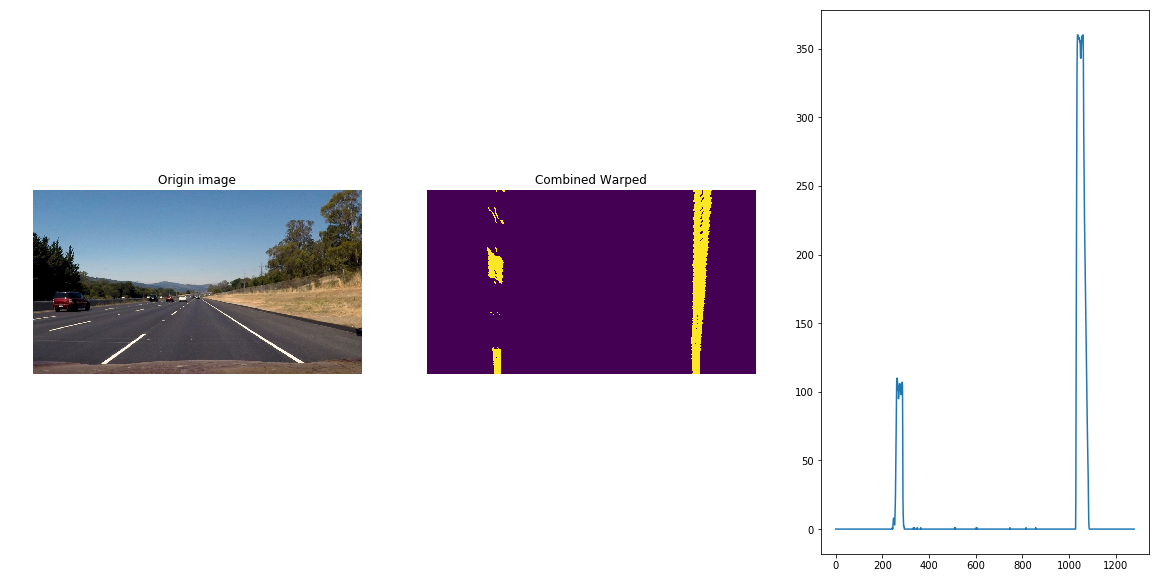

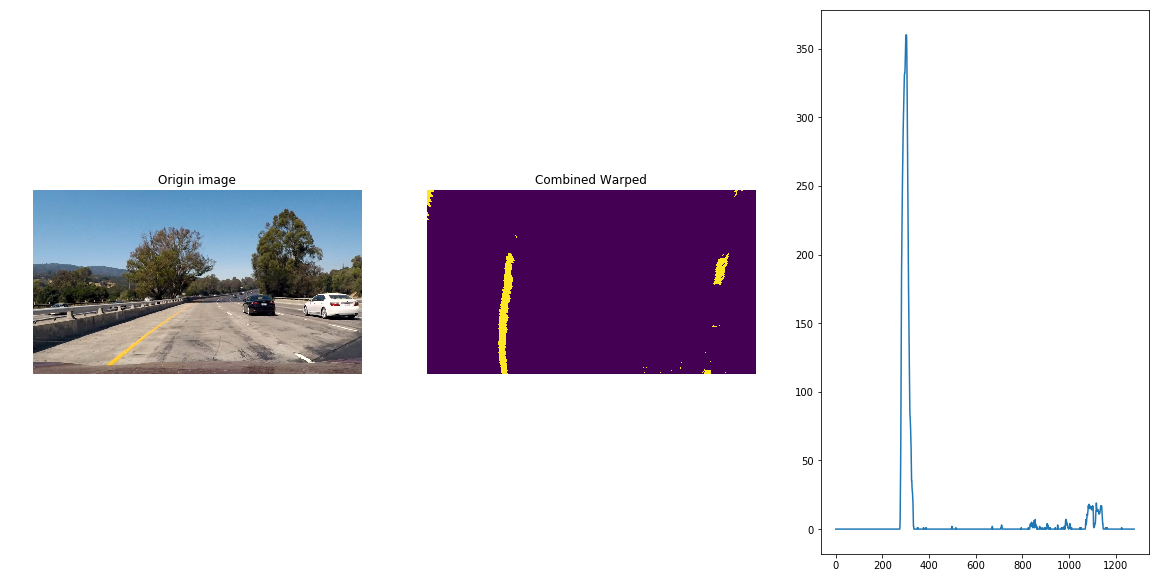

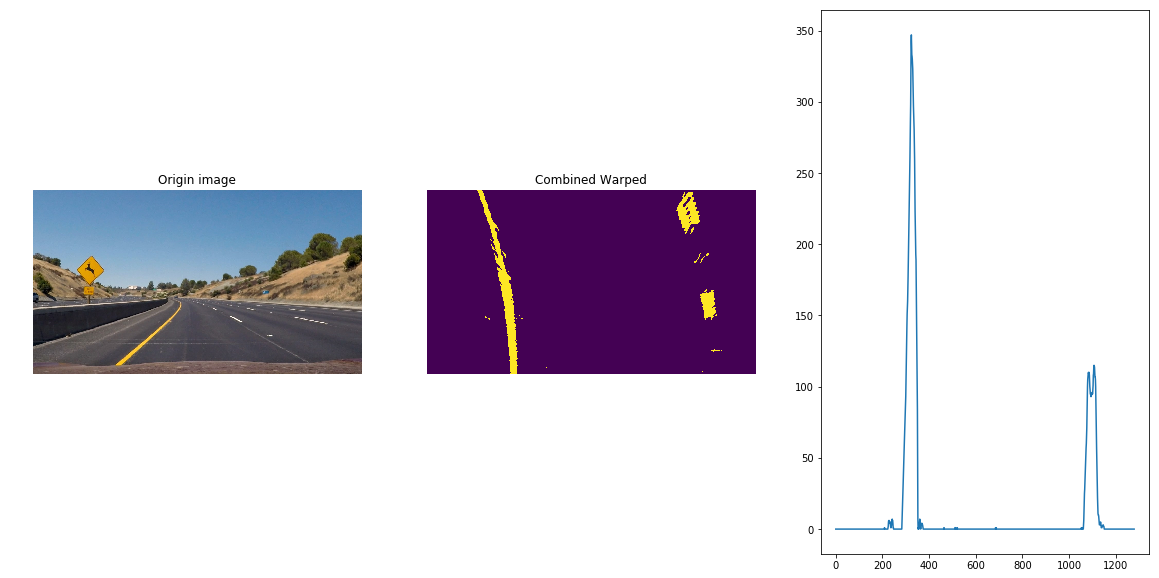

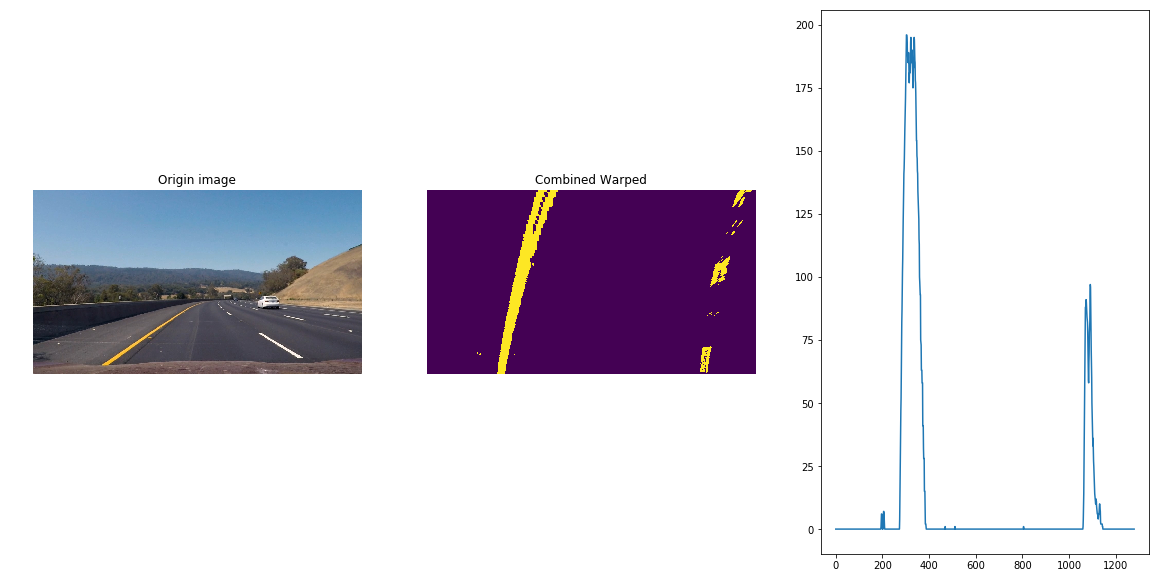

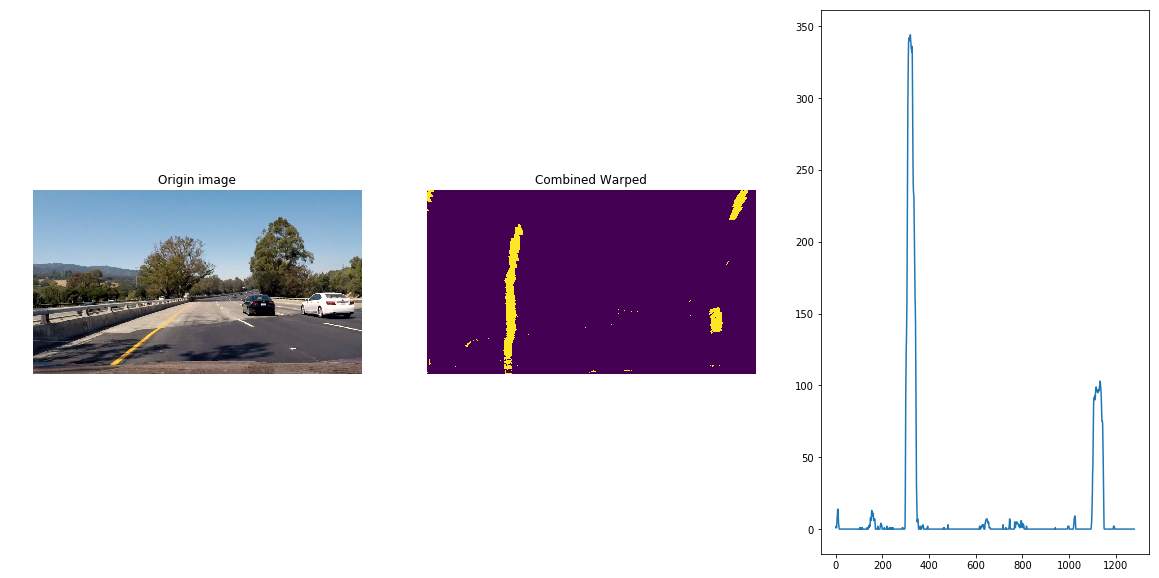

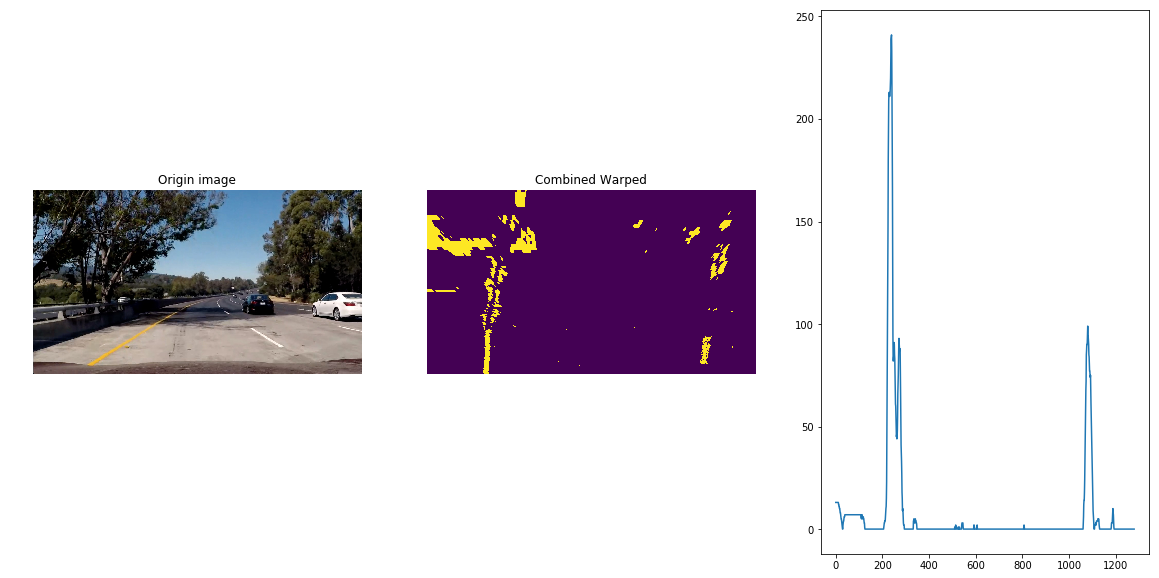

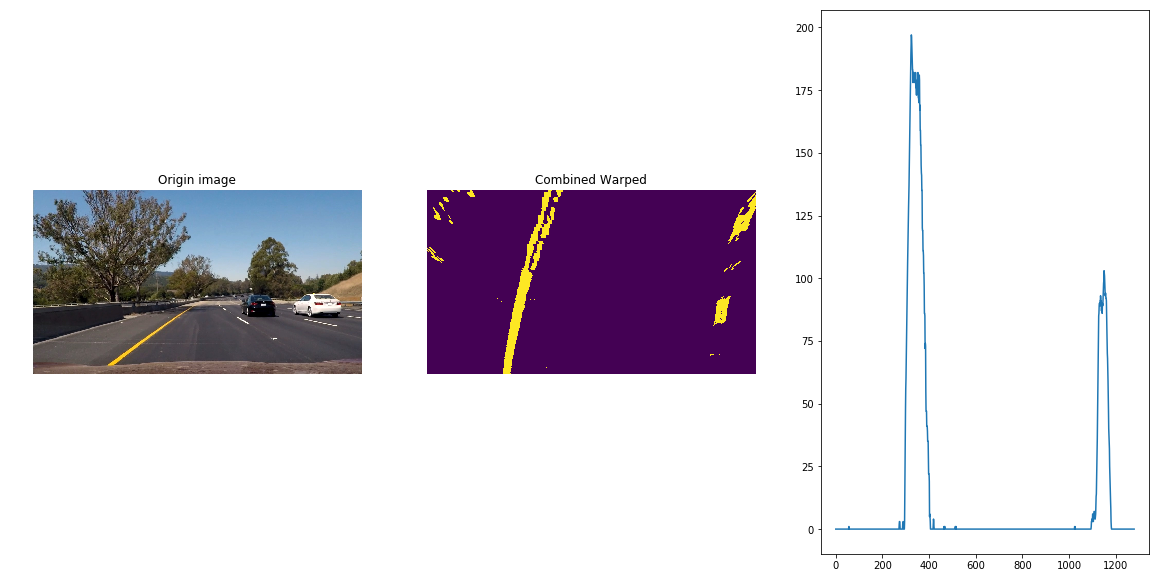

In [187]:
import os

files = os.listdir('./test_images')
files = [ './test_images/{}'.format(file) for file in files ]
for file in files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    undistorted_img = undistort_func(img, mtx, dist)
    color_binary, combined_binary = combine_binary_func(undistorted_img)
    combined_binary_warped, _, Minv = warp_image(combined_binary, src, dst, (img.shape[1], img.shape[0]))
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.set_title("Origin image")
    ax1.imshow(img)
    ax1.axis("off")
    
    ax2.set_title("Combined Warped")
    ax2.imshow(combined_binary_warped)
    ax2.axis("off")

    # Take a histogram of the bottom half of the image
    histogram = np.sum(combined_binary_warped[np.int(combined_binary_warped.shape[0]/2):,:], axis=0)

    plt.plot(histogram)

## Step 5: Find the lane lines
Implement Sliding Windows and Fit a Polynomial to Find the lane lines. Here we apply function in program to find the lane line and get the curvature of them.

In [193]:
def get_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    y_eval = np.max(ploty)
    
    # Calculate curvature in pixel-space.
    
    # left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    # right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # print(left_curverad, right_curverad)
    ## Example values: 1926.74 1908.48
    
    # Convert from pixels to metres.
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Calculate Lane Deviation from center of lane:
    # First we calculate the intercept points at the bottom of our image, then use those to 
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    
    return left_curverad, right_curverad, lane_deviation

def find_lane_lines(binary_warped, debug=False):
    
    if debug == True:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    l, r, d = get_curvature(leftx, lefty, rightx, righty, ploty, binary_warped.shape)
    
    if debug == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img
    else:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d

Now we can apply this function on the test image.

(0.0, 1280.0, 720.0, 0.0)

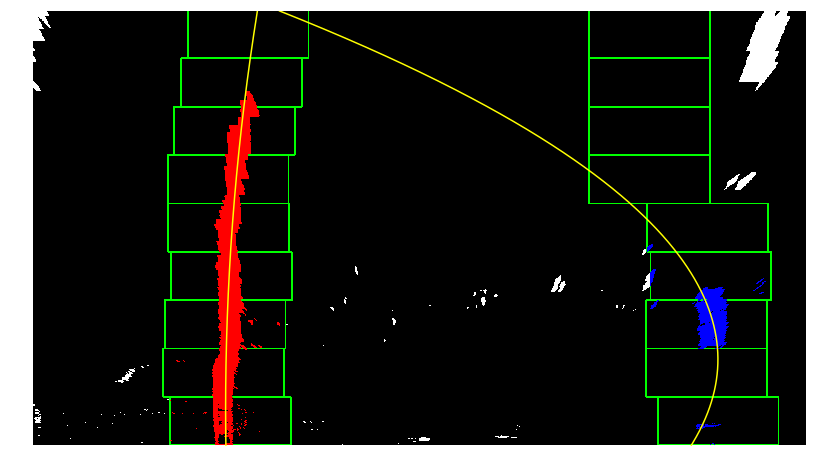

In [222]:
img = cv2.imread("test_images/test4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort_func(img, mtx, dist)
color_binary, combined_binary = combine_binary_func(undistorted_img)
combined_binary_warped, _, Minv = warp_image(combined_binary, src, dst, (img.shape[1], img.shape[0]))
left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img = find_lane_lines(combined_binary_warped, debug=True)

plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off")

## Step 6: Draw the Detected Line on the Origin Image
Finally, we should draw the detected line on the origin image, the function below imply thing.

True

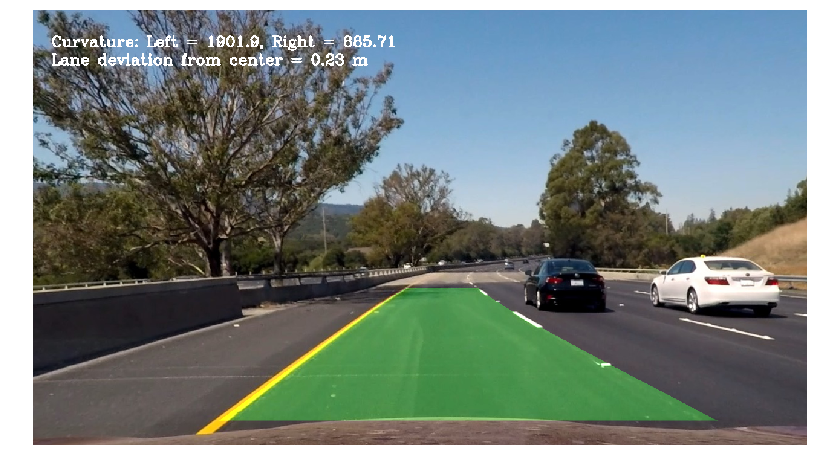

In [203]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2)) 
    cv2.putText(result, curvature_text, (30, 60), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255, 255, 255), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation)
    cv2.putText(result, deviation_text, (30, 90), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255, 255, 255), 2)
        
    return result

result = draw_lanes_on_image(combined_binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, l, r, d)
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off")

# save as file
binary = 255 * result.astype("uint8")
cv2.imwrite("output_images/final_result.jpg", result)

So, we get the whole step of achievement about lane line detection. Now we can apply it on video.

In [206]:
def process_image(image):
    undistorted_img = undistort_func(image, mtx, dist)
    color_binary, combined_binary = combine_binary_func(undistorted_img)
    plt.figure(figsize=(20,10))
    plt.imshow(combined_binary)
    plt.axis("off")
    combined_binary_warped, _, Minv = warp_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
    
    left_fitx, right_fitx, ploty, _, _, l, r, d = find_lane_lines(combined_binary_warped)
    lane_lines_img = draw_lanes_on_image(combined_binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, l, r, d)
    return lane_lines_img

(-0.5, 1279.5, 719.5, -0.5)

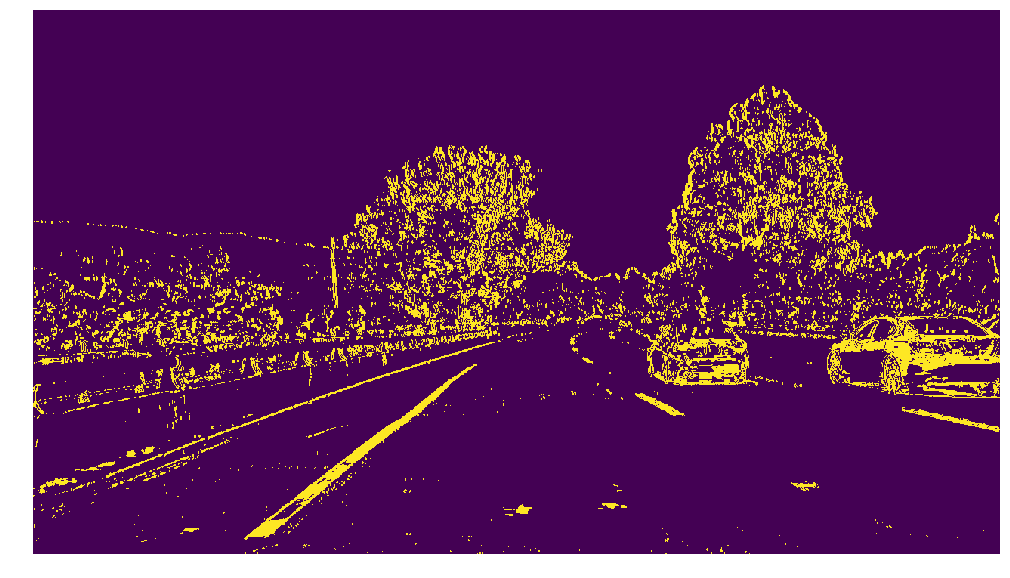

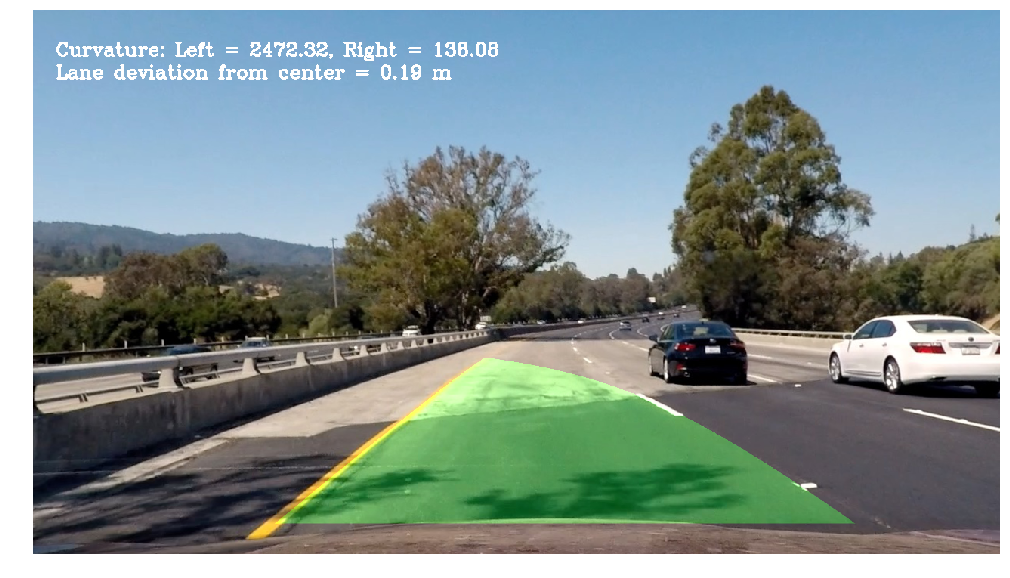

In [221]:
# Run on a test image
img = cv2.imread("test_images/test4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = process_image(img)

plt.figure(figsize=(20,10))
plt.imshow(result)
plt.axis("off")

In [182]:
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image)  #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [04:37<00:00,  4.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 4min 42s, sys: 1min 8s, total: 5min 51s
Wall time: 4min 37s


In [183]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [114]:
video_challenge_output = "output_images/project_video_challenge_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|██████████| 485/485 [01:02<00:00,  7.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 1min 17s, sys: 15.1 s, total: 1min 32s
Wall time: 1min 2s


In [117]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_challenge_output))